In [2]:
# imports
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Database Connectie

In [3]:
DB_USER = "s1144085"
DB_PASS = "9515"
DB_HOST = "95.217.3.61"
DB_PORT = "5432"
DB_NAME = "minor_s1144085"
SCHEMA_NAME = "INMINDAA_project"

In [4]:
DATABASE_URL = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(DATABASE_URL)

# Afhankelijke en Onafhankelijke variabelen

In [5]:
dependent_variable = 'opnamen_per_1000_inwoners' # 15.2 Ov. zwangerschap eind. misgeboorte, 20 tot 45 jaar

armoede_variable = 'g_hh_sti' # Gemiddelde gestandaardiseerd inkomen van huishouden * 1000 euro
hittestress_variable = 'pet_gem' # Gevoelstemperatuur (niet afgerond)
huisartsen_variable = 'per_1e4' # Wiskundige notatie van de gemiddelde huisartsen dichtheid per 10.000 inwoners.
leefbarometer_variable = 'lbm_score' # Leefbaarheidsscore

independent_variables = [
    armoede_variable,
    hittestress_variable,
    huisartsen_variable,
    leefbarometer_variable
]

In [6]:
def select_variables():
    query = f"""
    SELECT
        pc4_code,
        AVG({dependent_variable}) AS opnamen_per_1000_inwoners,
        AVG({hittestress_variable}) AS pet_gem,
        AVG({armoede_variable}) AS g_hh_sti,
        AVG({huisartsen_variable}) AS per_1e4,
        AVG({leefbarometer_variable}) AS lbm_score
    FROM "{SCHEMA_NAME}".{"fact_rapportage"}
    GROUP BY pc4_code
    ORDER BY pc4_code
    """
    return pd.read_sql(query, con=engine)

df = select_variables()

df.head(20)

print(f"Highest value:", df[armoede_variable].max())

Highest value: 63.70000076293945


# Gegevensvoorbereiding

## Imputatie

In [7]:
# Function to extract the first two digits of a PC4 code
def get_two_digit_prefix(pc4_code):
    return str(pc4_code)[:2]

# Function to get all PC4 codes with the same two-digit prefix
def get_same_prefix_pc4_codes(target_pc4, all_pc4_codes):
    target_prefix = get_two_digit_prefix(target_pc4)
    return [pc4 for pc4 in all_pc4_codes if get_two_digit_prefix(pc4) == target_prefix and pc4 != target_pc4]

# Function to impute missing values for avg_g_hh_sti using the mean of PC4 codes with the same two-digit prefix
def impute_by_prefix(df, target_pc4, column):
    # Get PC4 codes with the same two-digit prefix
    same_prefix_pc4_codes = get_same_prefix_pc4_codes(target_pc4, df['pc4_code'].values)

    # Filter DataFrame for PC4 codes with the same prefix and non-null values in the target column
    prefix_means = df[df['pc4_code'].isin(same_prefix_pc4_codes)][column]
    prefix_means = prefix_means.dropna()

    if not prefix_means.empty:
        # Return mean of PC4 codes with the same prefix
        return prefix_means.mean()
    else:
        # Fallback to global mean if no non-null values in the prefix group
        imputer = SimpleImputer(strategy='mean')
        valid_values = df[column].dropna().values.reshape(-1, 1)
        if len(valid_values) > 0:
            imputer.fit(valid_values)
            return imputer.transform([[np.nan]])[0][0]
        return np.nan  # If no valid values exist, return NaN

# Create a copy of the DataFrame to impute
df_imputed = df.copy()

# Impute missing values for avg_g_hh_sti
column = 'g_hh_sti'
missing_pc4 = df_imputed[df_imputed[column].isna()]['pc4_code'].unique()

for pc4 in missing_pc4:
    # Get rows for this pc4_code
    mask = df_imputed['pc4_code'] == pc4
    # Impute missing values using the mean of PC4 codes with the same two-digit prefix
    imputed_value = impute_by_prefix(df_imputed, pc4, column)
    df_imputed.loc[mask & df_imputed[column].isna(), column] = imputed_value

# Check for remaining missing values
print("Missing values after imputation:")
print(df_imputed.isna().sum())

Missing values after imputation:
pc4_code                     0
opnamen_per_1000_inwoners    0
pet_gem                      0
g_hh_sti                     0
per_1e4                      0
lbm_score                    0
dtype: int64


## Normalisatie

In [8]:
# Normalize the independent variables
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df, columns):
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

df_normalized = normalize_data(df_imputed, independent_variables)

# Regressie analyse

In [9]:
# Prepare data for regression
X = df_normalized[independent_variables]
y = df_normalized[dependent_variable]

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Get coefficients and intercept
coefficients = pd.DataFrame({
    'Variable': independent_variables,
    'Coefficient': model.coef_
})
intercept = model.intercept_

# Calculate R-squared
y_pred = model.predict(X)
r_squared = r2_score(y, y_pred)

# Print results
print('Regression Analysis Results')
print('==========================')
print('Coefficients:')
print(coefficients.to_string(index=False))
print(f'\nIntercept: {intercept:.4f}')
print(f'R-squared: {r_squared:.4f}')

Regression Analysis Results
Coefficients:
 Variable  Coefficient
 g_hh_sti    12.571558
  pet_gem     4.769750
  per_1e4     8.180323
lbm_score   -15.374010

Intercept: 22.5032
R-squared: 0.0388


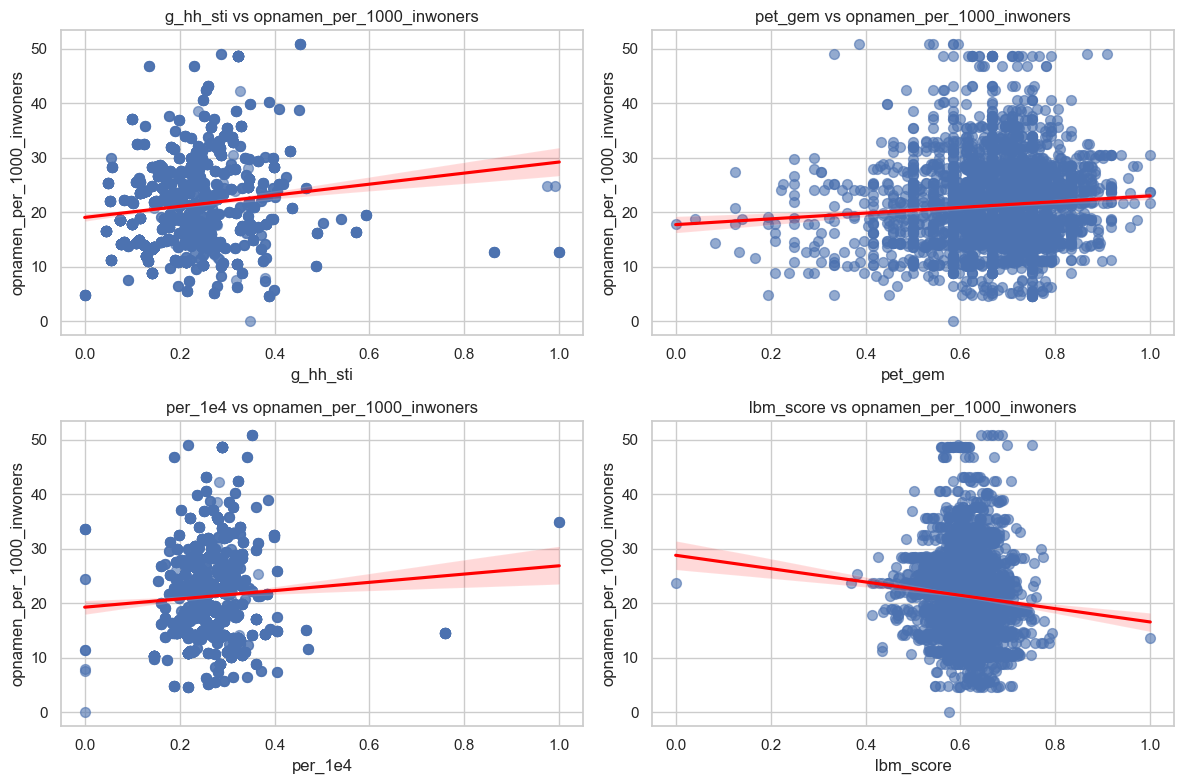

In [11]:
# Set style for better visualization
sns.set(style="whitegrid")

# Create a figure with subplots (2x2 grid for 4 independent variables)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Flatten the 2x2 array for easier iteration

# Plot each independent variable against the dependent variable
for i, var in enumerate(independent_variables):
    # Scatter plot with regression line
    sns.regplot(x=var, y=dependent_variable, data=df_normalized, ax=axes[i],
                scatter_kws={'s': 50, 'alpha': 0.6}, line_kws={'color': 'red'})

    # Set title and labels
    axes[i].set_title(f'{var} vs {dependent_variable}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel(dependent_variable)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

opnamen_per_1000_inwoner: zwangerschap eind. misgeboorte, 20 tot 45 jaar
g_hh_sti = Gemiddelde gestandaardiseerd inkomen van huishouden * 1000 euro
pet_gem =  Gevoelstemperatuur (niet afgerond)
per_1e4 = Wiskundige notatie van de gemiddelde huisartsen dichtheid per 10.000 inwoners.
lbm_score = Leefbaarheidsscore